# DEPRECATED in favor of using Messari's subgraphs and cleaner code

## Objectives

- Establish meaningful grouping of address by clustering DEX traders and LP
    - Feature Extraction:
        - with or without balances at swap time (web3py fetch balance at block)
    - Dimensionality reduction:
        - UMAP / tSNE or PCA / ICA
    - Clustering:
        - DBSCAN
        - silhouette evaluation
    **Deliverable**
    - Visualization:
        - scatter plot with color-coded returns? (TBD)

**Secondary objective: identify which group has the most profitable activity**
- Triggered Average of price by swap in/out by group of addresses

- Predict the return of the next candle based on the "history" of activity of the groups of addresses
    - Feature extracion
        - 

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from py0xcluster.utils import web3_utils, query_utils
from py0xcluster.main_classes.former_classes import Pools, TradesDEX, SwapProvider
from py0xcluster.main_classes.former_classes import days_interval_tuples

In [7]:
Pools()

### Getting pairs with the highest liquidity

In [8]:
uni2_pools = Pools('univ2')
pools_summary, full_results = uni2_pools.get_pools(
    min_daily_volume = 50000,
    min_daily_txns = 100,
    min_txns_per_token = 50000,
    start_date = (2022,10,25),
    end_date = (2022,11,1),
    days_batch_size = 30,
    min_days_in_ranking = 4
    )
print('nb pools:', pools_summary.shape[0])
pools_summary.head(50)

Queriying from 2022-10-25 00:00:00 to 2022-11-01 00:00:00
34 pairs dropped over 41
nb pools: 7


,pairAddress,dailyTxns,dailyVolumeUSD,reserveUSD,token0.totalLiquidity,token1.totalLiquidity,token0.txCount,token1.txCount,token0.symbol,token1.symbol,token0.id,token1.id
0,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,3561.0,8.475537e+06,9.599266e+07,9.778655e+07,2.859635e+05,8226750.0,89493337.0,USDC,WETH,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
1,0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852,2335.0,3.699824e+06,3.461334e+07,2.859635e+05,5.305623e+07,89493337.0,7444298.0,WETH,USDT,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xdac17f958d2ee523a2206206994597c13d831ec7
2,0xd3d2e2692501a5c9ca623199d38826e513033a17,188.0,1.105582e+06,2.060246e+07,8.704065e+05,2.859635e+05,855837.0,89493337.0,UNI,WETH,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
3,0xa478c2975ab1ea89e8196811f51a7b7ade33eb11,403.0,1.225315e+06,1.480227e+07,3.423080e+07,2.859635e+05,2587368.0,89493337.0,DAI,WETH,0x6b175474e89094c44da98b954eedeac495271d0f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
4,0x6033368e4a402605294c91cf5c03d72bd96e7d8d,235.0,8.312008e+05,3.617915e+06,2.211578e+07,2.859635e+05,122572.0,89493337.0,X2Y2,WETH,0x1e4ede388cbc9f4b5c79681b7f94d36a11abebc9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
5,0xd17e88b13e53029f356d46aba44b5640b35c8e9c,655.0,9.810812e+05,1.437123e+06,2.859635e+05,8.055238e+08,89493337.0,55978.0,WETH,WCI,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc5a9bc46a7dbe1c6de493e84a18f02e70e2c5a32
6,0xf29450019834d7874b4e306275c4334326ac27f1,907.0,1.147668e+06,4.311114e+05,1.650185e+07,2.859635e+05,58399.0,89493337.0,THE,WETH,0x0cba60ca5ef4d42f92a5070a8fedd13be93e2861,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2


### Extracting all "big" swaps from these pairs

In [4]:
uni2_trades = TradesDEX('X')
uni2_pools.pair_addresses

all_swaps = uni2_trades.get_swaps(
    pair_addresses = uni2_pools.pair_addresses[:33],
    min_amoutUSD = 5000,
    start_date = (2022,10,28),
    end_date = (2022,11,1),
    pairs_batch_size = 3,
    days_batch_size = 15
)

from 2022-10-28 00:00:00 to 2022-11-01 00:00:00
swaps collected so far: 2085
swaps collected so far: 2525
swaps collected so far: 3585
swaps collected so far: 3920
swaps collected so far: 4269
swaps collected so far: 4483
swaps collected so far: 4625
outputs: 4625 trades


In [5]:
all_swaps

,id,timestamp,sender,to,amount0In,amount1In,amount0Out,amount1Out,amountUSD,transaction.id,pair.token0.symbol,pair.token0.id,pair.token1.symbol,pair.token1.id
0,0x2612a98d156e73668b8e4976cb861c427a77dd3e8434...,2022-10-31 22:56:35,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x65b9ad105b95290bcde1ed91f2f6688232ad5782,5.230000e+03,0.000000,0.000000,3.329993,5221.124322,0x2612a98d156e73668b8e4976cb861c427a77dd3e8434...,USDC,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
1,0x7f0e2dde23bd3cc5c3cd1b568c91df2bc062fc9b1c1d...,2022-10-31 22:24:47,0xd249942f6d417cbfdcb792b1229353b66c790726,0xd249942f6d417cbfdcb792b1229353b66c790726,1.484420e+04,0.000000,0.000000,9.459001,14823.991947,0x7f0e2dde23bd3cc5c3cd1b568c91df2bc062fc9b1c1d...,USDC,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
2,0x1337a621e74624bb2eb39c9e834ae9efd4fa9e1d7c5c...,2022-10-31 22:24:47,0xa57bd00134b2850b2a1c55860c9e9ea100fdd6cf,0x56178a0d5f301baf6cf3e1cd53d9863437345bf9,1.077526e+04,0.000000,0.000000,6.862528,10758.487083,0x1337a621e74624bb2eb39c9e834ae9efd4fa9e1d7c5c...,USDC,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
3,0x0d43b339edd12e7785a1785885ef559f171c990d175f...,2022-10-31 22:22:59,0xbfef411d9ae30c5b471d529c838f1abb7b65d67f,0xbfef411d9ae30c5b471d529c838f1abb7b65d67f,0.000000e+00,5.765631,1300.079371,0.000000,9017.548827,0x0d43b339edd12e7785a1785885ef559f171c990d175f...,UNI,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
4,0xbcb41f1b75166f29a71b9e398aa65c942adba152d44f...,2022-10-31 22:22:11,0xbfef411d9ae30c5b471d529c838f1abb7b65d67f,0xbfef411d9ae30c5b471d529c838f1abb7b65d67f,0.000000e+00,3.570886,806.608456,0.000000,5584.875088,0xbcb41f1b75166f29a71b9e398aa65c942adba152d44f...,UNI,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0x0a6a40f4b7ec281b7487e298c93b60db5c0fa22d0aef...,2022-10-28 01:48:11,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,2.644723e+09,0.000000,0.000000,10332.742880,10333.384095,0x0a6a40f4b7ec281b7487e298c93b60db5c0fa22d0aef...,HDRN,0x3819f64f282bf135d62168c1e513280daf905e06,USDC,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
138,0x30b5776864825cc36f6cc43424e44db26e59f783705b...,2022-10-28 01:06:23,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x93e66231386fdbcade355ae81edbd8421daf7bbd,5.086351e+05,0.000000,0.000000,3.372135,5121.600632,0x30b5776864825cc36f6cc43424e44db26e59f783705b...,THE,0x0cba60ca5ef4d42f92a5070a8fedd13be93e2861,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
139,0x91e6e291c62e769305c0ede85e57b2cb9a73b1682c38...,2022-10-27 23:51:11,0xd10c70000bb40b1c4579b522a7597eb8db2d10a7,0xd10c70000bb40b1c4579b522a7597eb8db2d10a7,0.000000e+00,5.293930,860769.429904,0.000000,8015.337733,0x91e6e291c62e769305c0ede85e57b2cb9a73b1682c38...,THE,0x0cba60ca5ef4d42f92a5070a8fedd13be93e2861,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
140,0x585f5340b931dc2e158d77706df57edbb4ea641dd2c7...,2022-10-27 23:51:11,0xd10c70000bb40b1c4579b522a7597eb8db2d10a7,0xd10c70000bb40b1c4579b522a7597eb8db2d10a7,8.607694e+05,0.000000,0.000000,5.315213,8047.561513,0x585f5340b931dc2e158d77706df57edbb4ea641dd2c7...,THE,0x0cba60ca5ef4d42f92a5070a8fedd13be93e2861,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2


### 

In [11]:
conf = dict()
conf['QUERIES_PATH'] = r'C:\Users\phar0732\Documents\GitHub\py0xcluster\py0xcluster\queries'
conf['subgraph_url'] = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'
conf['token'] = 'randomtoken'
conf['page_size'] = 1000
swaps = SwapProvider(conf)

In [12]:
swaps.get_swaps()


AttributeError: 'SwapProvider' object has no attribute 'get_swaps'

In [14]:
start_date = (2022,10,28)
end_date = (2022,11,1)

def datelim_batch_generator(start_date, end_date, days_batch_size):
    days_batch_lim = [dates_lim for dates_lim in days_interval_tuples(start_date, end_date, days_batch_size)]
        
    full_df = pd.DataFrame()
    for d_batch_nb, days_batch in enumerate(days_batch_lim):
        start_batch = query_utils.timestamp_tuple_to_unix(days_batch[0])
        end_batch = query_utils.timestamp_tuple_to_unix(days_batch[1])

In [17]:
uni2swaps = SwapProvider(conf)
uni2swaps.get_swaps(
    pair_addresses = None, 
    min_amoutUSD = 2000, 
    start_date= None, 
    end_date= None,
    pairs_batch_size = 1,
    days_batch_size = 10,
    verbose = True
    ) 


AttributeError: 'SwapProvider' object has no attribute 'get_swaps'

In [13]:
all_swaps.groupby('to')['id'].count().sort_values(ascending=False).head(50)

to
0x56178a0d5f301baf6cf3e1cd53d9863437345bf9    891
0x000000000dfde7deaf24138722987c9a6991e2d4    380
0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45    332
0xf021f084477242fe6835c67234b4345de4db19e1    153
0xc6093fd9cc143f9f058938868b2df2daf9a91d28    151
0x57c1e0c2adf6eecdb135bcf9ec5f23b319be2c94    135
0xbfef411d9ae30c5b471d529c838f1abb7b65d67f    129
0xf2f400c138f9fb900576263af0bc7fcde2b1b8a8    122
0x000000000035b5e5ad9019092c665357240f594e    106
0x7a250d5630b4cf539739df2c5dacb4c659f2488d    103
0x1111111254fb6c44bac0bed2854e76f90643097d     68
0x9507c04b10486547584c37bcbd931b2a4fee9a41     59
0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852     59
0xe8c060f8052e07423f71d445277c61ac5138a2e5     47
0xef6fa3307af6ab6ddcc4826c4945041dd5c18d4b     46
0xd249942f6d417cbfdcb792b1229353b66c790726     46
0x98c3d3183c4b8a650614ad179a1a98be0a8d6b8e     45
0x4a137fd5e7a256ef08a7de531a17d0be0cc7b6b6     40
0x2a6812a728c61b1f26ffa0749377d6bd7bf7f1f8     38
0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc     

<AxesSubplot: >

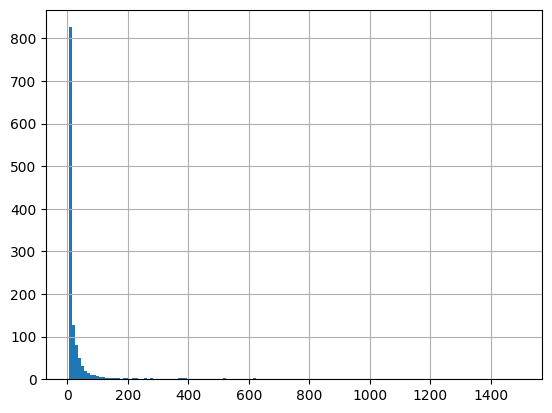

In [19]:
all_swaps.groupby('to')['id'].count().hist(bins=range(5,1500,10))

In [20]:
uni2_pools = Pools('univ3', 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3')
pools_summary, full_results = uni2_pools.get_pools(
    min_daily_volume = 50000,
    min_daily_txns = 100,
    min_txns_per_token = 50000,
    start_date = (2022,8,1),
    end_date = (2022,11,1),
    days_batch_size = 30,
    min_days_in_ranking = 4
    )
print('nb pools:', pools_summary.shape[0])
pools_summary.head(50)


Queriying from 2022-08-01 00:00:00 to 2022-08-31 00:00:00
[{'locations': [{'line': 4, 'column': 17}], 'message': 'Type `Query` has no field `pairDayDatas`'}]


KeyError: "None of [Index(['dailyTxns', 'reserveUSD', 'dailyVolumeUSD', 'token0.totalLiquidity',\n       'token0.txCount', 'token1.totalLiquidity', 'token1.txCount'],\n      dtype='object')] are in the [columns]"

In [ ]:
etherscan_API_path = r'C:\Users\phar0732\Documents\ID\etherscan\etherscan_api.csv'
etherscan_token = str(pd.read_csv(etherscan_API_path, header=None).values[0][0])
etherscan_token

address0 = '0x424a31f5caa3155437ebed0ce80169639f6689d5'
address1 = '0x728BD56A965dC3B9aDA745301C2f731599d2fe13'


In [ ]:
web3_utils.get_nonce('0x424a31f5caa3155437ebed0ce80169639f6689d5')

1